In [20]:
import pandas as pd
from sklearn.base import BaseEstimator
import numpy as np
import pdb
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import shuffle
from math import log2
from sklearn.svm import SVC
import itertools 
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

class Support_Vector_Machine(BaseEstimator):
    """ This is my implimentation of a Support Vector Machine. 
    This can be used to for binary classification into positive and negative classes.

    I am using the sci-kit learn project template as the structure for this class.
    
    

    Parameters
    ----------
    learning_rate : A parameter used to multiple by the cost gradient when iterating to control the step size.
    n_iter : Determines how many iterations the gradient will be calculated until it meets an accectable tolerance 
    tolerance :Once the previous_cost-new_cost is within the range new_cost-tolerance the model will stop fitting and return the weights W
    C : Regularisation hyperparameter used to control the 'softness' of the margin
    lam : lambda value for regularisation in the cost function to penalise high values for W

    Attributes
    ----------
    X_ : ndarray, shape (n_samples, n_features)
        The input passed during :meth:`fit`.
    y_ : ndarray, shape (n_samples,)
        The labels passed during :meth:`fit`.
    classes_ : ndarray, shape (n_classes,)
        The classes seen at :meth:`fit`.
    """
    def __init__(self, learning_rate=100e-6, n_iter=1e+3, tolerance=10e-3 , C=50e-3, lam=0.5, verbose=False):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.tolerance = tolerance
        self.C = C
        self.lam=lam
        self.verbose = verbose        


    def fit(self, X, y):
        """
        Training an SVM is an optimisation problem where the objective is to maximise the distance between a hyperplane and the closest datapoint for any weight and bias (W, b).
        The equation for a seperating hyperplane is (W).(X) + b = 0 where W is a weight vector, X is the input vector and b is a bias term.
                    
        The distance between the hyperplanes is 2/||W|| - so the goal is to minimise the magnitude of W and therefore maximise the 
        distnce between the hyperplanes with the condition no points lie between the two hyperplanes.
        This minimising variable can be re-written as (||W||^2)*(1/2) for convenience, it is now a quadratic with one global minimum.
        
        So writing the eq. for hyperplanes for the two classes gives:
             (W).(Xi) + b = 1 for positive class (yi=1)
             (W).(Xi) + b = -1 for negative class (yi=-1)
        This can be generalised for both classes as yi is known and can be multiplied by the above equations to give the form:
            yi(Xi.W+b)-1=0

        We want to minimise ||W|| and maximise b by iterating through possible values for W and keeping the W and b that satisfy the above equation 
        and picking the W and b that minimise ||W||. This will be done using Stochastic Gradient Descent and the bias term will be evaluated in the W vector.

        The cost funciton is described by the equation:
        J= (||W||^2)/2  +  (C/N)*SUMALL(maxvalue(0, 1-yi*W*xi)) 

        The gradient of this cost funciton is :
        DJ = 1/N SUMALL(w) if the max(0, 1-yi*W*xi) = 0 and satisfies the general form of the hyperplane equation or
        DJ = 1/N SUMALL(w-C*yi*xi) where is does not satify the eqn.




        Parameters
        ----------
        X : The training input samples.
        y : The target values. An array of int.

        Returns
        -------
        self : Returns self.W 
        """
        # Check that X and y have correct shape
        X, y = check_X_y(X, y, accept_sparse=True)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y

        # Initialise the weight vector with length the same as the number of features being analysed and give each coefficient a value of 1.
        W = np.ones(X.shape[1])  
        residuals=[]
        prev_cost=np.inf

        # For each iteration, calculate the weights.
        for step in range(self.n_iter):
            # For each X value evaluate the gradient at that point with the given weights and subtract the gradient*learning rate from the weights to refine the W vector
            for index, value in enumerate(X): 
                W = W-self.learning_rate*gradient(W, value,  y[index], self.C) 
                cost = cost_function(W,X, y,self.C, self.lam)
                residuals.append(cost)
                if abs(prev_cost-cost) < self.tolerance:
                    self.W = W
                    self.residuals=residuals
                    return(self.W)
                    break
                prev_cost=cost
                
        self.W = W
        self.residuals=residuals
        return(self.W)

    def predict(self, X):
        """ 
        Calculate the dot product of transpose(W) and Xi. If the result is a positive number then assign it the positive class, vice versa for the negative class

        Parameters
        ----------
        X : The input samples.

        Returns
        -------
        y : The label for each sample either 1 or -1 depending on the sign of the dot product of W.T and Xi
         """
        # Check is fit had been called
        #check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)
        output = []
        for i in X:
            if np.dot(self.W.T,i)>0:
                output.append(1)
            else:
                output.append(-1)
        return(output)
    
   
def information_gain(df, target, columns):
    """
    Calculate the information gain for all the columns to be presented at the feature selection screen. 
    Mean value will be used to bucket the values.

    Parameters
    ----------
    df : The input dataframe.
    target : The chosen target variable.
    columns : The chosen independant variables

    Returns
    -------
    df_output: datafame, shape (n_columns, 3) where columns are:
    Column : Column of the dataframe
    Mean Value : mean value of the independant variable
    Information Gain: Information Gain given by the variable binned above and below the mean variable value. 

    """
    df_output = pd.DataFrame()
    
    target_vals = list(set(df[target]))
    val1 = target_vals[0]
    val2 = target_vals[1]
    
    df_entropy = -(len(df[df[target]==val1])/len(df))*log2(len(df[df[target]==val1])/len(df)) - (len(df[df[target]==val2])/len(df))*log2(len(df[df[target]==val2])/len(df))
    
    
    for col in columns:        
        mean_val = np.mean(df[col])
        high_val= df[df[col]>=mean_val]
        low_val = df[df[col]<mean_val]
        try:
            # Some columns like rain have no fires above the mean value so the below equation breaks down - this is a very significant feature to include
            if len(set(high_val[target])) ==2 :
                high_exp1 = -(len(high_val[high_val[target]==val1]) / len(high_val))*log2(len(high_val[high_val[target]==val1])/len(high_val)) 
                high_exp2 = -(len(high_val[high_val[target]==val2]) / len(high_val))*log2(len(high_val[high_val[target]==val2])/len(high_val))
                high_ent =  high_exp1 + high_exp2
            else:
                high_ent=0

            if len(set(low_val[target])) ==2 :
                low_exp1 = -(len(low_val[low_val[target]==val1]) / len(low_val))*log2(len(low_val[low_val[target]==val1])/len(low_val)) 
                low_exp2 = -(len(low_val[low_val[target]==val2]) / len(low_val))*log2(len(low_val[low_val[target]==val2])/len(low_val))
                low_ent =  low_exp1 + low_exp2
            else:
                low_ent=0

            info_gain = df_entropy - (len(high_val)/len(df))*high_ent - (len(low_val)/len(df))*low_ent
            df_output = df_output.append([[col,np.round(mean_val,2),np.round(info_gain, 2)]])
        except:
            pass
    df_output = df_output.rename(columns={0:'Column', 1:"Mean Value", 2:"Information Gain"})
    return(df_output)
        
        

def feature_selection(df):
    """
    Allows user input to pick the dependant and independant variables. 
    Once the dependant variable is chosen the information gain for the independant variables is calculated to help the user pick out useful features. 
    To calculate information gain variables were binned according to the feature mean value 
        - this is not useful in the case of categorical data but the user should know that, this is just to assist the feature selection process.

    Parameters
    ----------
    df : The input dataframe.
    
    Returns
    -------
    df_output: datafame, shape (n_columns, 3) where columns are:
    Column : Column of the dataframe
    Data Type: Column showing the dtype of the independant variables
    Mean Value : mean value of the independant variable
    Information Gain: Information Gain given by the variable binned above and below the mean variable value. 
    
    """
    print("\n")
    print(df.dtypes)
    #target='yes'
    target = input('Pick the target variable: ')
    
    df[target] = [x.strip() for x in df[target]]
    df[target] = df[target].replace({'no':-1, 'yes':1})
    df_cols = df.drop(target ,axis=1)
   
    ig = information_gain(df, target, df_cols.columns)
    info_cols = pd.DataFrame(df_cols.dtypes)
    info_cols.reset_index(inplace=True)
    info_cols = info_cols.rename(columns={'index':'Column', 0:'Data Type'})
    info_cols= info_cols.merge(ig, on='Column').sort_values("Information Gain" ,ascending=False)
    print("\n")
    print("Information gain calculated for bins either side of mean values for each feature")
    print(info_cols)
    #cols = "rainfall, humidity, buildup_index, drought_code"
    cols = input("Please enter the desired columns for anaylsis (use a comma seperate the features): ")
    cols = [x.strip() for x in cols.split(',')]
    return target, cols

def normalise(df, column):
    """
    Function to normalise the data in the datasets columns - 
    -1, 1 normalising is done through applying 2 * (x-min(x) / (max(x)-min(x)
    This has a negative impact on the models performance but included because was covered in lectures and to show work done.
    
    Parameters
    ----------
    df : The input dataframe.

    column : Column of the dataframe to be normalised

    Returns
    -------
    Normlised series

    """
    return 2*(df[column]-min(df[column]))/(max(df[column]) - min(df[column]))-1
    

def cost_function(W, X, y, C, lam):
    """
    The cost funciton is described by the equation below and will be evaluated to determine if the model has achieved an acceptably 
    low cost function before the number of iterations has been reached.
    A complexity penalty has been added too to force the model to favour low weight values in W
    
    J(W) = emperical_cost(W) + lambdaComplexity(W)

    J(W)= 1/2(W.T*W)  +  (C/N)*SUMALL(maxvalue(0, 1-yi*W*xi)) + lambda*Complexity(|W|)


    Parameters
    ----------
    W : Stores the current weights of the model
    X : Xi values for the given point
    y : dependant variable for Xi
    C: regularisation hyper parameter for tuning the soft margin strength
    lam: regularisation hyper parameter for penalising large W values
    

    Returns
    -------
    computed cost of the resulting W values for a given Xi
    
    """
    for i in range(len(X)):
        
        N = len(X)
        # Evaluate for the left side of the '+'. Dot product of a vector on itself returns the magnitude
        hyper_plane_distance = np.max([0,1-(y[i]*np.dot(X[i],W.T))])

        emperical_cost = (1/2) * np.dot(W.T,W) + (C/N)*np.sum(hyper_plane_distance)
        complexity = lam*np.linalg.norm(W)
        return (emperical_cost+complexity)




def gradient(W, X, y, C):
    '''
    Calculate the hinge loss at a point for given values of W, Xi, yi and return the value for the SVM to evaluate the next values for W if HL!=0.
    
    Parameters
    ----------
    W :1D numpy array, shape (n_features)
            Stores the current weights of the model
    X : Xi values for the given point
    y : dependant variable for Xi
    C: regularisation hyper parameter for tuning the soft margin strength
  

    Returns
    -------
    grad: New set of weights to be used in the next iteration of the model

    '''
    
    grad = np.zeros(len(W))
    # Calculate hinge loss the point at  Xi, yi using W. If less than 0,  assign 0.
    hl = np.max([0, 1 - y * np.dot(W.T,X)])
    
    # If the max value of the point is 0 then loss is minimised for thie W, return it to the model
    if hl == 0:
        grad = W
    else:
        # HL has not been minimised yet, return this W to the model to be iterated over next time
        grad = W - (C * y * X)
    return grad




def cross_val(clf, X_, y_, n_iter):
    
    """
    SK Learns cross_val_score was not working with my implimentation of the SVM so the below code shuffles and splits the dataset into 2/3 and 1/3 for training and validation. 
    For every step in n_iter, the validation set will iterate through the 3 folds and a model will be fitted on the training data and evaluated on the validation set.
    The first 1/3 elements are taken for validation and the remainder are training. 

    Once the first 1/3 items have been used for validaiton they are concatenated onto the end of the training set and these first 1/3 elements are removed from the top of the training set.
    In the next loop a fresh 1/3 of the dataset will be used for vlalidaiton.

    Drawbacks of this function is a lack of stratified sampling - Some validation sets may have an unrepresentative quantity of a particular class. 
    While not ideal, this is a known draw back and can be lived with.
    
    Parameters
    ----------
    clf : the chosen classifier - must be compatible with the sci-kit learn API for fit() and predict()
    X : X values 
    y : y values
    n_iter: how many iterations are needed
  

    Returns
    -------
    Nothing

    Will print out the iteraion, validaion fold and f1 score for each model being evaluated. A mean F1 score is calculated at the end.

    """
    
    output_scores=[]
    
    for step in range(n_iter):
        # Shuffle the dataset every step in the iteration
        X,y = shuffle(X_,y_)
        # For each fold in the iteraion
        for fold in range(3):
            # Take the top 1/3 of the dataset for validation, rest for training
            index_slicer = len(X)//3
            X_val, y_val = X[ :index_slicer ], y[ : index_slicer]
            X_train, y_train = X[index_slicer: ], y[index_slicer: ]

            # Append the first 1/3elements to the end of the array and then slice them off the start.
            # By always treating the first j elements as the validation set and the remainder as the training set, 
            # I can do n-fold CV without adapting my Support_Vector_machine class to work with sci kit learns cv.

            X, y =np.concatenate((X_train,X_val)),np.concatenate((y_train,y_val))
            #pdb.set_trace()

            clf.fit(X_train, y_train)
            clf_predicts = clf.predict(X_val)
            f1 = f1_score(y_val, clf_predicts)
            print(f'Iteration: {step}. Fold: {fold}  F1 score: {f1}')
            output_scores.append(f1)
    #pdb.set_trace()
    print(f'Mean F1 is: {np.mean(output_scores)}')



In [2]:
df = pd.read_csv("../Data/wildfires.txt", delimiter='\t')

target, cols = feature_selection(df)

for i in cols:
    df[i]= normalise(df, i)
    
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
    
X_train, X_test, y_train, y_test = train_test_split(df[cols], df[target], test_size=0.3, random_state=10)

    
dataset = [X_train, X_test, y_train, y_test]
for i in dataset:
    i.reset_index(inplace=True, drop=True)


#X_train = np.hstack([X_train, np.ones(X_train.shape[0]).reshape(-1,1)])
#X_test = np.hstack([X_test, np.ones(X_test.shape[0]).reshape(-1,1)])
X2D = pca.fit_transform(X_train)
X2D_test = pca.transform(X_test)



yes               object
year               int64
temp               int64
humidity           int64
rainfall         float64
drought_code     float64
buildup_index    float64
day                int64
month              int64
wind_speed         int64
dtype: object


Information gain calculated for bins either side of mean values for each feature
          Column Data Type  Mean Value  Information Gain
5  buildup_index   float64       16.54              0.30
3       rainfall   float64        0.82              0.25
4   drought_code   float64       48.54              0.23
1           temp     int64       31.91              0.18
2       humidity     int64       62.28              0.11
6            day     int64       15.69              0.03
7          month     int64        7.55              0.03
0           year     int64     2011.98              0.00
8     wind_speed     int64       16.45              0.00


In [3]:
my_svm = Support_Vector_Machine(C=0.01, lam=0.1, learning_rate=0.01, n_iter=1000, tolerance=1e-6, verbose=True)


In [4]:
#cross_val(my_svm, X2D, y_train, 10)

In [5]:
my_svm.fit(X2D, y_train)

array([0.01581549, 0.0108967 ])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
x_vals = np.arange(0,len(my_svm.residuals))
p = sns.lineplot(x=x_vals, y=my_svm.residuals)
p = sns.lineplot(x=x_vals, y=my_svm.tolerance)
p.set_xticks(x_vals[::50]);
p.set_xticklabels(x_vals[::50]);
p.set_title("Num Iterations to accecptable convergence")
p.set_xlabel("Iterations")
p.set_ylabel("Residual cost")
plt.show()

In [6]:
my_y_train_predictions = my_svm.predict(X2D)
my_y_predictions = my_svm.predict(X2D_test)

In [7]:
my_svm_score = f1_score(y_test, my_y_predictions)
my_svm_score

0.6923076923076923

In [8]:
from sklearn.svm import SVC
svm = SVC()
skl_svm = svm.fit(X2D, y_train)
skl_y_train_predictions = skl_svm.predict(X2D)
skl_y_predicitons = skl_svm.predict(X2D_test)

In [9]:
from sklearn.metrics import f1_score
f1_score(y_test, skl_y_predicitons)

0.84375

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'learning_rate':[100e-6], 'n_iter':[10000, 100000], 'tolerance':[10e-3, 1e-3, 100e-6], 'C':[0.01,00.1], 'lam':[0.1, 0.3, 0.5]}]

In [ ]:
my_svm = Support_Vector_Machine(verbose=True)

In [ ]:
grid_search = GridSearchCV(my_svm, param_grid, cv=10, scoring='f1', return_train_score=True)

In [ ]:
grid_search.fit(X2D, y_train)

In [ ]:
grid_search.best_estimator_
grid_y_predictions = grid_search.predict(X2D_test)
f1_score(y_test, grid_y_predictions)

In [ ]:
my_svm =Support_Vector_Machine(C=1e-3, lam=100e-3, learning_rate=10e-3, n_iter=int(10e+4), tolerance=1e-6, verbose=True)

In [ ]:
my_svm.fit(X2D, y_train)

In [ ]:
my_y_predictions = my_svm.predict(X2D_test)

In [ ]:
cost_function(my_svm.W,X2D, y_train,C=0.1, lam=0.1 )

In [ ]:
output = str(list(zip(y_test,my_y_predictions)))
with open('Output.txt', 'w') as f:
    f.writelines(output)
    
f.close()

# Plotting

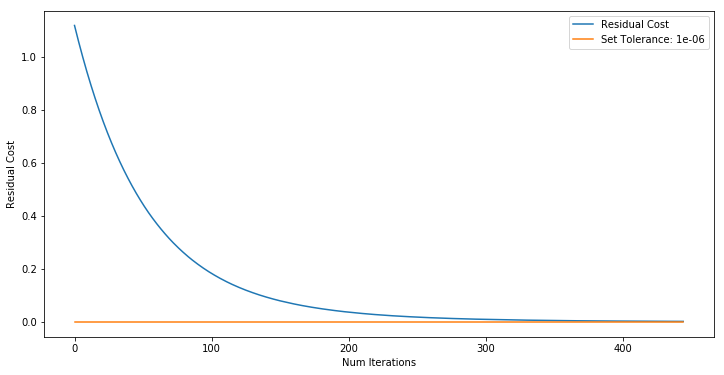

In [15]:
# plotting residuals for my model

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(my_svm.residuals, label='Residual Cost')
ax.plot(np.array([my_svm.tolerance for i in my_svm.residuals]), label=f"Set Tolerance: {my_svm.tolerance}")
#lt.xlim(left=0,right=500)
plt.xlabel("Num Iterations")
plt.ylabel("Residual Cost")
plt.legend()

In [53]:
x1 = [np.round(i[0],3) for i in X2D_test]
x2 = [np.round(i[1],3) for i in X2D_test]
df = pd.DataFrame(data={'x1':x1, 'x2':x2, 'y_actual':y_test, 'y_pred':my_y_predictions})

In [54]:
x1_range = np.arange(min(x1), max(x1), .05)
x2_range = np.arange(min(x2), max(x2), .05)

In [57]:
decision_boundary_=[]
pos_db_= []
neg_db_= []
for i,j in itertools.product(x1_range,x2_range):
    dot_prod = np.round(np.dot([i, j], my_svm.W),3)
    if dot_prod==0.00:
        decision_boundary_.append([i, j])
    elif (dot_prod >=.95) &( dot_prod <=1.05):
        pos_db_.append([i, j])
    elif (dot_prod <=-.95) &( dot_prod >=-1.05):
        neg_db_.append([i, j])
        
decision_boundary = pd.DataFrame(data=decision_boundary_, columns=['x1', 'x2'])
pos_db= pd.DataFrame(data=pos_db_, columns=['x1', 'x2'])
neg_db= pd.DataFrame(data=neg_db_, columns=['x1', 'x2'])

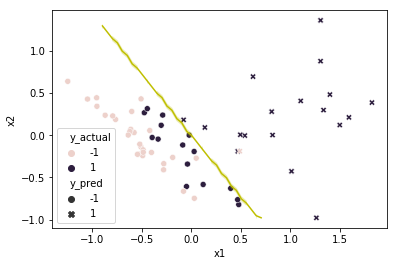

In [64]:
snsplot = sns.scatterplot(data=df, x='x1', y='x2',  hue='y_actual', style='y_pred')
snsplot = sns.lineplot(data=decision_boundary, x='x1', y='x2', color='y', linestyle='-')
snsplot = sns.lineplot(data=pos_db, x='x1', y='x2', color='k' )
snsplot = sns.lineplot(data=neg_db, x='x1', y='x2', color='k')
snsplot.figure.savefig("../Output/scatterplo4t.png")

In [ ]:
i,j

In [ ]:
test = pd.DataFrame([])

In [ ]:
test.append([[i, j]])

In [ ]:
x1 = [np.round(i[0],3) for i in X2D_test]
x2 = [np.round(i[1],3) for i in X2D_test]
df = pd.DataFrame(data={'x1':x1, 'x2':x2, 'y_actual':y_test, 'y_pred':my_y_predictions})

# create a range of x1 and x2 values to iterate over to plot the decision boundary where (W).(Xi) =0 (intercept term dropped during PCA for lack of variance)
x1_range = np.arange(min(x1), max(x1), .01)
x2_range = np.arange(min(x2), max(x2), .01)


decision_boundary_, pos_db_, neg_db_= [], [], []
# Iterate through all the possible values of x1 and x2 and define the support vectors and decision boundaries
for i,j in itertools.product(x1_range,x2_range):
    dot_prod = np.round(np.dot([i, j], my_svm.W),4)
    if dot_prod==0.00:
        decision_boundary_.append([i, j])
        # In case some points are not exact matches, allow a small tolerance
    elif (dot_prod >=.9900) &( dot_prod <=1.0100):
        pos_db_.append([i, j])
    elif (dot_prod <=-.9900) &( dot_prod >=-1.0100):
        neg_db_.append([i, j])

decision_boundary = pd.DataFrame(data=decision_boundary_, columns=['x1', 'x2'])
pos_db= pd.DataFrame(data=pos_db_, columns=['x1', 'x2'])
neg_db= pd.DataFrame(data=neg_db_, columns=['x1', 'x2'])

sns.scatterplot(data=df, x='x1', y='x2',  hue='y_actual', style='y_pred')
sns.lineplot(data=decision_boundary, x='x1', y='x2', color='y')
sns.lineplot(data=pos_db, x='x1', y='x2', color='b' )
sns.lineplot(data=neg_db, x='x1', y='x2', color='k')
plt.show()

In [ ]:
x1 = [np.round(i[0],3) for i in X2D_test]
x2 = [np.round(i[1],3) for i in X2D_test]
df = pd.DataFrame(data={'x1':x1, 'x2':x2, 'y_actual':y_test, 'y_pred':my_y_predictions})

# create a range of x1 and x2 values to iterate over to plot the decision boundary where (W).(Xi) =0 (intercept term dropped during PCA for lack of variance)
x1_range = np.arange(min(x1), max(x1), .01)
x2_range = np.arange(min(x2), max(x2), .01)


decision_boundary_, pos_db_, neg_db_= [], [], []
# Iterate through all the possible values of x1 and x2 and define the support vectors and decision boundaries
for i,j in itertools.product(x1_range,x2_range):
    dot_prod = np.round(np.dot([i, j], my_svm.W),4)
    if dot_prod==0.00:
        decision_boundary_.append([i, j])
        # In case some points are not exact matches, allow a small tolerance
    elif (dot_prod >=.9900) &( dot_prod <=1.0100):
        pos_db_.append([i, j])
    elif (dot_prod <=-.9900) &( dot_prod >=-1.0100):
        neg_db_.append([i, j])

decision_boundary = pd.DataFrame(data=decision_boundary_, columns=['x1', 'x2'])
pos_db= pd.DataFrame(data=pos_db_, columns=['x1', 'x2'])
neg_db= pd.DataFrame(data=neg_db_, columns=['x1', 'x2'])

sns.scatterplot(data=df, x='x1', y='x2',  hue='y_actual', style='y_pred')
sns.lineplot(data=decision_boundary, x='x1', y='x2', color='y')
sns.lineplot(data=pos_db, x='x1', y='x2', color='b' )
sns.lineplot(data=neg_db, x='x1', y='x2', color='k')
#plt.show()